## Praktikum 3
Dikumpulkan 26 Februari 2021
Ilma Aliya Fiddien (10117019)

### Mengimpor modul yang dibutuhkan

In [3]:
import numpy as np
from matplotlib import pyplot as plt
import sklearn.datasets as sds

### Menggenerasi Dataset
Fungsi diberikan di praktikum

In [4]:
class PlanarDataset(object):
    def __init__(self, points_per_class):
        self.N = points_per_class

    def load_dataset(self, shape):
        X, Y = getattr(self, "get_"+shape)()
        X, Y = X.T, np.expand_dims(Y, 0)
        return X, Y
        
    def get_circles(self):
        return sds.make_circles(n_samples=self.N, factor=.5, noise=.3)

    def get_moons(self):      
        return sds.make_moons(n_samples=self.N, noise=.2)

    def get_blobs(self):
        X, Y = sds.make_blobs(n_samples=self.N, random_state=5, n_features=2, centers=6)
        Y = Y%2
        return X, Y

    def get_quantiles(self):
        return sds.make_gaussian_quantiles(mean=None, cov=0.5, 
                                           n_samples=self.N, n_features=2, 
                                           n_classes=2, shuffle=True, 
                                           random_state=1)      

    def get_random(self):
        return np.random.rand(self.N, 2), np.random.randint(2, size=self.N)

    def get_plain(self):
        X, Y = sds.make_classification(n_samples=200, n_features=2, n_redundant=0, 
                                       n_informative=2, random_state=1, 
                                       n_clusters_per_class=1)
        rng = np.random.RandomState(2)
        X += 2 * rng.uniform(size=X.shape)
        return X, Y

    def get_flower(self):
        m = int(self.N / 2.)
        X = np.zeros((self.N,2)) 
        Y = np.zeros(self.N, dtype='uint8')
        a = 4 

        for j in range(2):
            ix = range(m*j, m*(j+1))
            t = np.linspace(j*3.12, (j+1)*3.12, m) + np.random.randn(m)*0.2 # theta
            r = a * np.sin(4*t) + np.random.randn(m)*0.2 # radius
            X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
            Y[ix] = j

        return X, Y

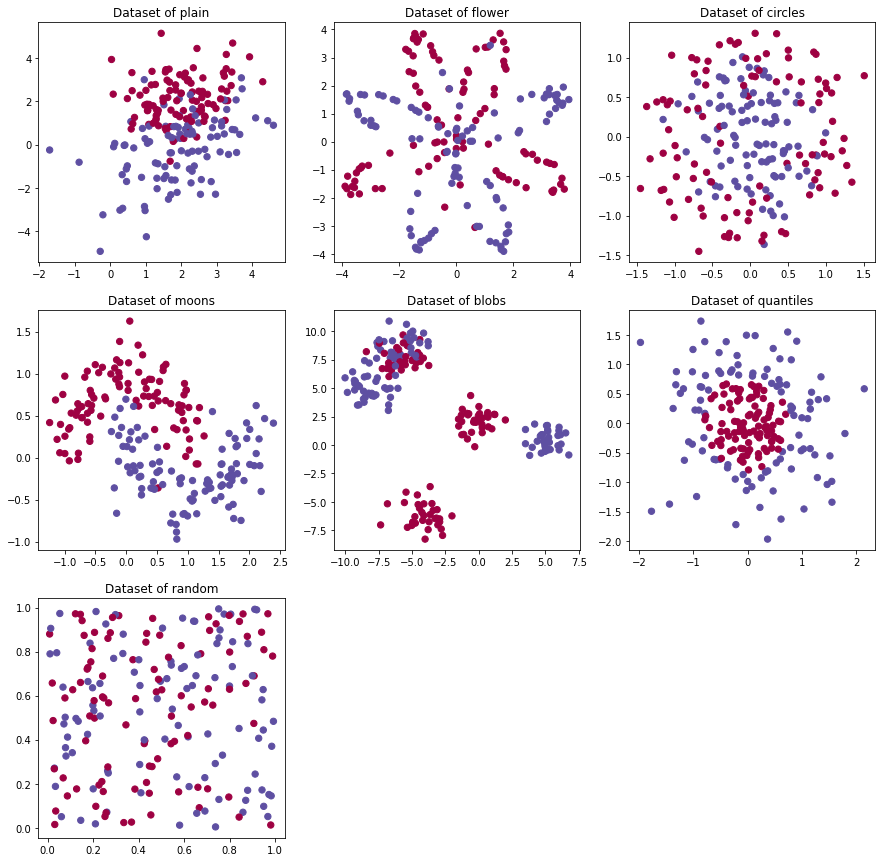

In [16]:
dataset_lst = [
    'plain', #0
    'flower', #1
    'circles', #2
    'moons', #3
    'blobs', #4
    'quantiles', #5 
    'random' #6
]
loader = PlanarDataset(200)
plt.figure(figsize=(15, 15))
DataSet = {}
for i, shape in enumerate(dataset_lst):
    plt.subplot(3, 3, i+1)
    plt.title("Dataset of "+shape)
    X, Y = loader.load_dataset(shape)
    DataSet[shape] = (X, Y)
    plt.scatter(X[0, :], X[1, :], c=Y, s=40, cmap=plt.cm.Spectral);

### Fungsi Pendukung

In [40]:
def plot_decision_boundary(model, X, y):
    """ Membuat 'batas keputusan', yakni pemisah  R2  menjadi 2 region saling lepas berdasarkan label """
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y, s=20, cmap=plt.cm.Spectral)
    
def sigmoid(x):
    """ Fungsi sigmoid """
    return 1 / (1+np.exp(-x))

In [11]:
def initialize_parameters(n_x, n_h, n_y):    
    """ inisialisasi parameter w dan b 
        n_x : ukuran vektor x | n_y : ukuran vektor y | n_h : banyak hidden layer 
    """
    w1 = np.random.randn(n_h, n_x)
    b1 = np.zeros((n_h, 1))
    w2 = np.random.randn(n_y, n_h)
    b2 = np.zeros((n_y, 1))
    
    return w1, w2, b1, b2

### Fungsi-Fungsi Pembelajaran

In [14]:
def forward_propagation(X, w1, w2, b1, b2):
    """ melakukan perambatan maju """
    Z1 = np.dot(w1, X) + b1
    A1 = np.tanh(Z1) 
    Z2 = np.dot(w2, A1) + b2
    A2 = sigmoid(Z2)
        
    return A1, A2

def backward_propagation(A1, A2, w2, X, Y):
    """ melakukan perambatan mundur """
    m = X.shape[1]

    dZ2 = A2 - Y
    dw2 = np.dot(dZ2, A1.T) / m
    db2 = np.sum(dZ2, axis=1, keepdims=True) / m
    dZ1 = np.dot(w2.T, dZ2) * (1. - np.power(A1, 2)) # menggunakan turunan fungsi tanh
    dw1 = np.dot(dZ1, X.T) / m
    db1 = np.sum(dZ2, axis=1, keepdims=True) / m
    
    return dw1, dw2, db1, db2

def update_parameters(parameters, grads, learning_rate = 1.2):
    """ memperbarui parameter hasil perambatan mundur """
    w1, w2, b1, b2 = parameters
    dw1, dw2, db1, db2 = grads

    w1 -= learning_rate * dw1
    b1 -= learning_rate * db1
    w2 -= learning_rate * dw2
    b2 -= learning_rate * db2
        
    return w1, w2, b1, b2


def predict(parameters, X):    
    _, A2 = forward_propagation(X, *parameters)
    predictions = (A2 > 0.5)
    
    return predictions

### Fungsi penghitung akurasi

In [13]:
def compute_cost(A2, Y):
    m = Y.shape[1] # number of example
    logprobs = np.multiply(np.log(A2+0.01), Y) + np.multiply(np.log(1-A2+0.01), 1-Y)
    cost = - np.sum(logprobs) / m
    return float(np.squeeze(cost))  # makes sure cost is the dimension we expect. 

def get_accuracy(parameters, X, Y):
    predictions = predict(parameters, X)
    correctly_predicted = np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T)
    accuracy = float(correctly_predicted)/float(Y.size)*100  
    print("train accuracy: {} %".format(accuracy))

### Fungsi utama

In [15]:
def nn_model(X, Y, n_h, num_iterations = 10000, learning_rate = 1.2, print_cost=False):    
    n_x = X.shape[0]
    n_y = Y.shape[0]
    parameters = initialize_parameters(n_x, n_h, n_y)

    for i in range(0, num_iterations):
        A1, A2 = forward_propagation(X, *parameters)
        cost = compute_cost(A2, Y)
        grads = backward_propagation(A1, A2, parameters[1], X, Y)
        parameters = update_parameters(parameters, grads, learning_rate)
        if print_cost and i % (num_iterations // 10) == 0:
            print ("Cost after iteration %i: %f" %(i, cost))

    return parameters

## Menerapkan Model
### Melatih model
Dipilih 3 hidden neuron

Cost after iteration 0: 0.747073
Cost after iteration 10000: 0.182964
Cost after iteration 20000: 0.178477
Cost after iteration 30000: 0.174288
Cost after iteration 40000: 0.171314
Cost after iteration 50000: 0.169365
Cost after iteration 60000: 0.168022
Cost after iteration 70000: 0.167028
Cost after iteration 80000: 0.166245
Cost after iteration 90000: 0.165599
train accuracy: 94.5 %


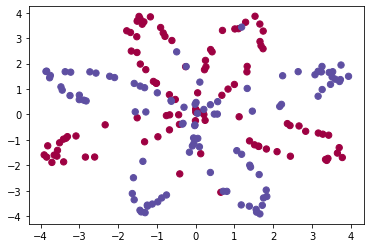

In [24]:
hidden_neuron = 3

X, Y = DataSet["flower"]
plt.scatter(X[0, :], X[1, :], c=Y, s=40, cmap=plt.cm.Spectral);
parameters = nn_model(X, Y, hidden_neuron, 100000, 0.5, True)
get_accuracy(parameters, X, Y)

### Plot pembagian region

Text(0.5, 1.0, 'Decision Boundary for hidden layer size 3')

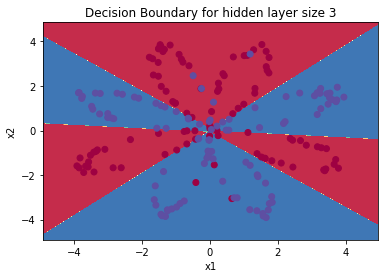

In [25]:
plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
plt.title("Decision Boundary for hidden layer size " + str(hidden_neuron))

## Analisis Sensitivitas Banyaknya Neuron


#################################### Dataset PLAIN
Accuracy for 1 hidden units: 87.00 %
Accuracy for 6 hidden units: 87.00 %
Accuracy for 11 hidden units: 84.00 %
Accuracy for 16 hidden units: 86.00 %
Accuracy for 21 hidden units: 86.50 %
Accuracy for 26 hidden units: 87.00 %
Accuracy for 31 hidden units: 86.50 %
Accuracy for 36 hidden units: 85.00 %
Accuracy for 41 hidden units: 86.50 %
Accuracy for 46 hidden units: 82.00 %


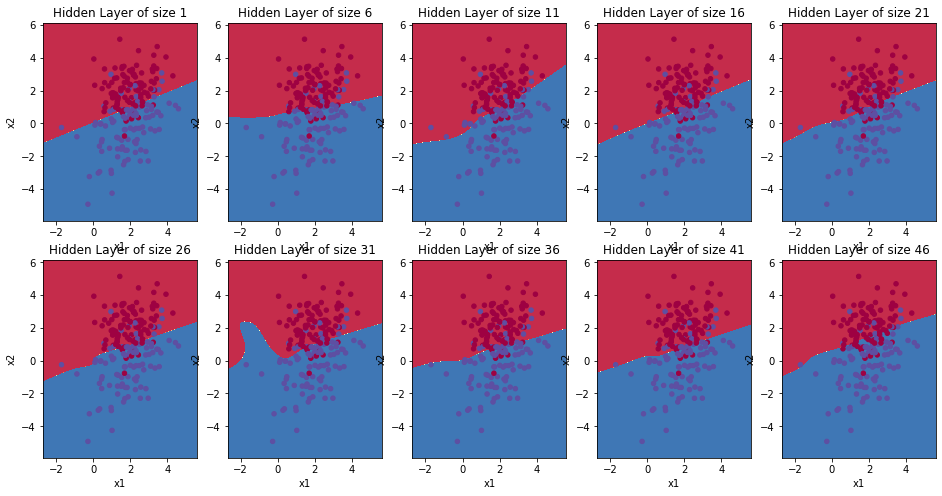


#################################### Dataset FLOWER
Accuracy for 1 hidden units: 53.50 %
Accuracy for 6 hidden units: 86.50 %
Accuracy for 11 hidden units: 88.00 %
Accuracy for 16 hidden units: 91.50 %
Accuracy for 21 hidden units: 90.00 %
Accuracy for 26 hidden units: 89.50 %
Accuracy for 31 hidden units: 86.00 %
Accuracy for 36 hidden units: 89.00 %
Accuracy for 41 hidden units: 86.50 %
Accuracy for 46 hidden units: 90.00 %


<Figure size 432x288 with 0 Axes>

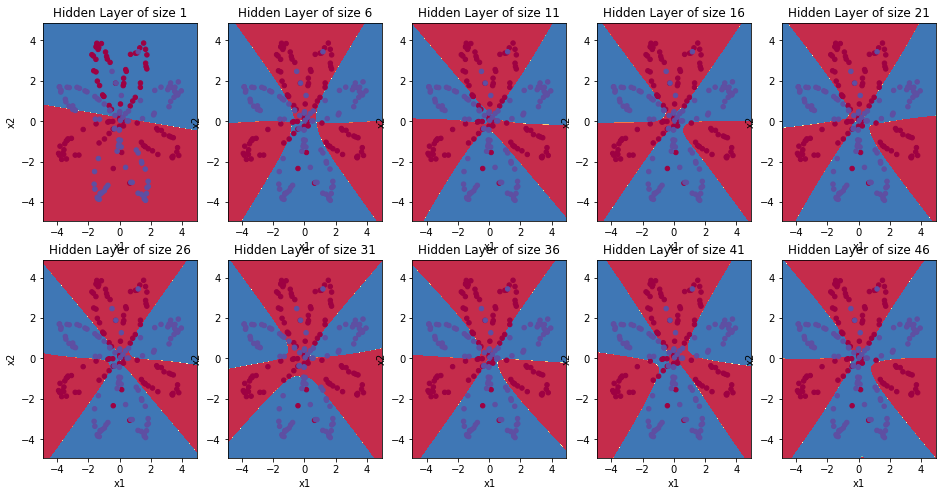


#################################### Dataset CIRCLES
Accuracy for 1 hidden units: 51.50 %
Accuracy for 6 hidden units: 46.00 %
Accuracy for 11 hidden units: 48.00 %
Accuracy for 16 hidden units: 51.00 %
Accuracy for 21 hidden units: 51.50 %
Accuracy for 26 hidden units: 53.00 %
Accuracy for 31 hidden units: 47.50 %
Accuracy for 36 hidden units: 52.00 %
Accuracy for 41 hidden units: 48.50 %
Accuracy for 46 hidden units: 75.50 %


<Figure size 432x288 with 0 Axes>

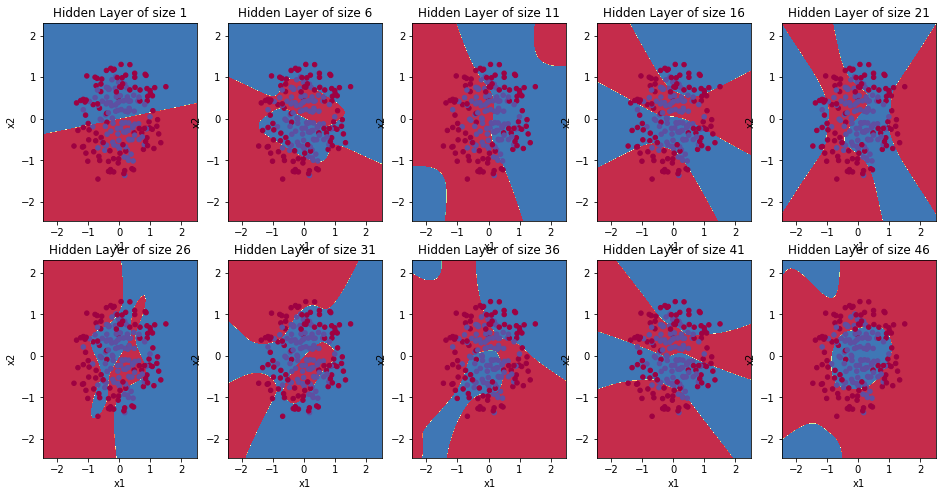


#################################### Dataset MOONS
Accuracy for 1 hidden units: 71.50 %
Accuracy for 6 hidden units: 84.50 %
Accuracy for 11 hidden units: 89.00 %
Accuracy for 16 hidden units: 87.50 %
Accuracy for 21 hidden units: 88.00 %
Accuracy for 26 hidden units: 89.00 %
Accuracy for 31 hidden units: 87.50 %
Accuracy for 36 hidden units: 88.50 %
Accuracy for 41 hidden units: 88.50 %
Accuracy for 46 hidden units: 87.50 %


<Figure size 432x288 with 0 Axes>

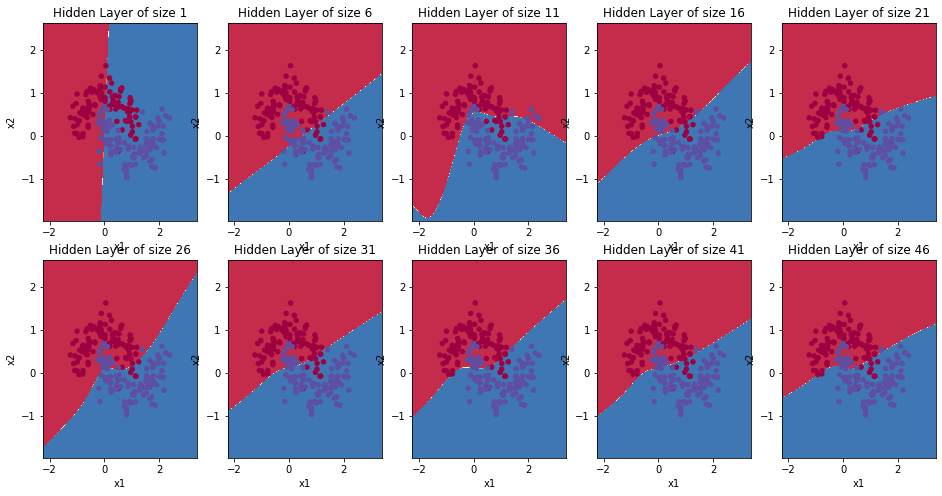


#################################### Dataset BLOBS
Accuracy for 1 hidden units: 49.00 %
Accuracy for 6 hidden units: 77.50 %
Accuracy for 11 hidden units: 80.00 %
Accuracy for 16 hidden units: 84.50 %
Accuracy for 21 hidden units: 80.00 %
Accuracy for 26 hidden units: 82.50 %
Accuracy for 31 hidden units: 81.50 %
Accuracy for 36 hidden units: 80.50 %
Accuracy for 41 hidden units: 79.50 %
Accuracy for 46 hidden units: 79.50 %


<Figure size 432x288 with 0 Axes>

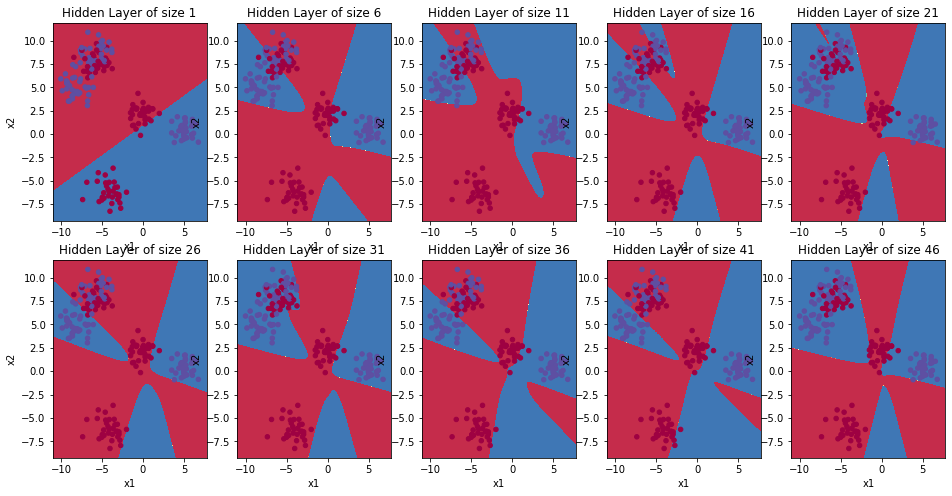


#################################### Dataset QUANTILES
Accuracy for 1 hidden units: 49.50 %
Accuracy for 6 hidden units: 57.00 %
Accuracy for 11 hidden units: 53.00 %
Accuracy for 16 hidden units: 50.00 %
Accuracy for 21 hidden units: 60.50 %
Accuracy for 26 hidden units: 58.50 %
Accuracy for 31 hidden units: 55.00 %
Accuracy for 36 hidden units: 53.00 %
Accuracy for 41 hidden units: 57.50 %
Accuracy for 46 hidden units: 49.50 %


<Figure size 432x288 with 0 Axes>

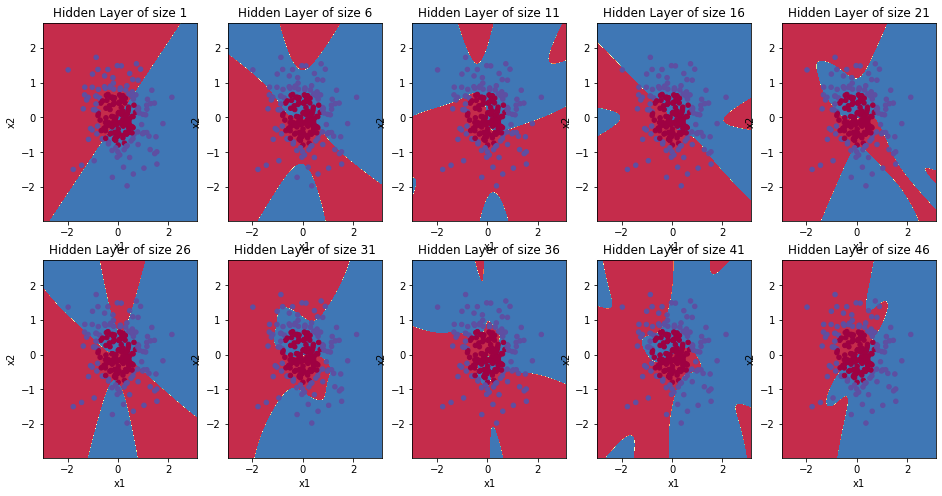


#################################### Dataset RANDOM
Accuracy for 1 hidden units: 48.00 %
Accuracy for 6 hidden units: 55.00 %
Accuracy for 11 hidden units: 54.00 %
Accuracy for 16 hidden units: 54.00 %
Accuracy for 21 hidden units: 53.50 %
Accuracy for 26 hidden units: 54.50 %
Accuracy for 31 hidden units: 53.00 %
Accuracy for 36 hidden units: 52.00 %
Accuracy for 41 hidden units: 46.50 %
Accuracy for 46 hidden units: 51.50 %


<Figure size 432x288 with 0 Axes>

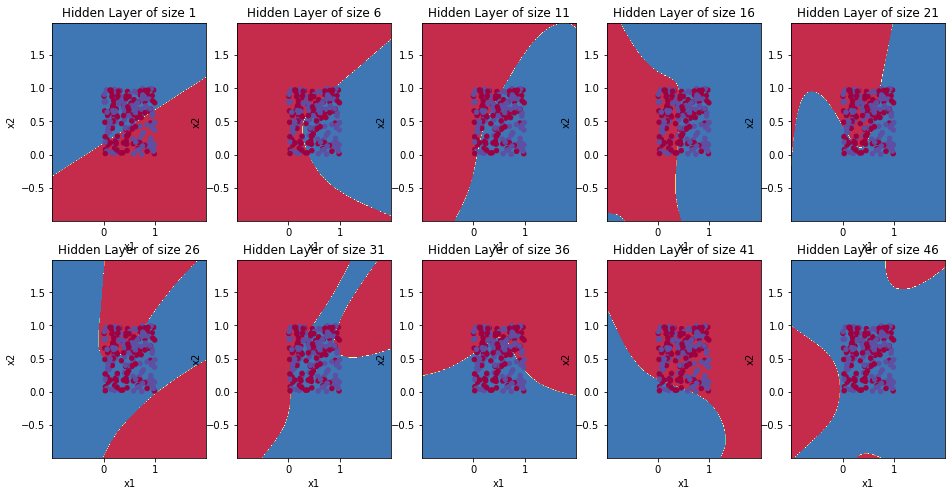

<Figure size 432x288 with 0 Axes>

In [42]:
for shape in DataSet:
    print("\n#################################### Dataset {}".format(shape.upper()))

    X, Y = DataSet[shape]
    plt.figure(figsize=(16, 8))
    hidden_layer_sizes = np.arange(1, 50, 5)
    accuracy = []
    
    for i, n_h in enumerate(hidden_layer_sizes):
        plt.subplot(2, 5, i+1)
        plt.title('Hidden Layer of size %d' % n_h)
        
        parameters = nn_model(X, Y, n_h, num_iterations = 20, learning_rate = .5)
        plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
        predictions = predict(parameters, X)
        acc = float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100)
        
        print ("Accuracy for {} hidden units: {:.2f} %".format(n_h, acc))
        accuracy.append(acc)
    plt.pause(0.05)
    plt.tight_layout()
# plt.plot()